In [ ]:
from typing import Annotated, Any

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Image
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import BaseMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from sentence_transformers import SentenceTransformer
from typing_extensions import TypedDict

In [43]:
# load the API key as the environemt variable
load_dotenv()

True

In [44]:
# generate synthetic data of advertised products
data = {
    "product_id": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "product_name": [
        "Men's Classic Cotton T-Shirt",
        "Women's High-Waisted Jeans",
        "Waterproof Hiking Boots",
        "All-Weather Hiking Backpack",
        "Merino Wool Hiking Socks",
        "男士经典棉T恤",  # Men's Classic Cotton T-Shirt
        "女士高腰牛仔裤",  # Women's High-Waisted Jeans
        "防水登山鞋",  # Waterproof Hiking Boots
        "智能手表",  # Smart Watch
        "无线蓝牙耳机",  # Wireless Bluetooth Headphones
    ],
    "description": [
        "A comfortable and durable t-shirt for everyday wear.",
        "Stylish and flattering jeans for any occasion.",
        "Durable, waterproof boots perfect for any trail or mountain.",
        "A spacious and comfortable backpack to carry all your gear.",
        "Warm and breathable socks designed for long hikes.",
        "舒适耐穿的日常T恤。",  # Comfortable and durable everyday T-shirt.
        "适合任何场合的时尚修身牛仔裤。",  # Stylish and flattering jeans for any occasion.
        "耐用、防水的靴子，适合任何小径或山脉。",  # Durable, waterproof boots perfect for any trail or mountain.
        "一款多功能智能手表，可追踪您的健康和通知。",  # An all-in-one smartwatch that tracks your health and notifications.
        "提供高品质音效和长续航的无线耳机。",  # Wireless earphones that deliver high-quality sound and long battery life.
    ],
    "category": [
        "Apparel",
        "Apparel",
        "Footwear",
        "Gear",
        "Apparel",
        "服装",  # Apparel
        "服装",  # Apparel
        "鞋类",  # Apparel
        "电子产品",  # Electronics
        "电子产品",  # Electronics
    ],
    "price": [
        25.00,
        75.00,
        120.00,
        90.00,
        15.00,
        150.00,
        450.00,
        700.00,
        1500.00,
        800.00,
    ],
}
product_catalog = pd.DataFrame(data)

In [45]:
product_catalog

,product_id,product_name,description,category,price
0,1,Men's Classic Cotton T-Shirt,A comfortable and durable t-shirt for everyday...,Apparel,25.0
1,2,Women's High-Waisted Jeans,Stylish and flattering jeans for any occasion.,Apparel,75.0
2,3,Waterproof Hiking Boots,"Durable, waterproof boots perfect for any trai...",Footwear,120.0
3,4,All-Weather Hiking Backpack,A spacious and comfortable backpack to carry a...,Gear,90.0
4,5,Merino Wool Hiking Socks,Warm and breathable socks designed for long hi...,Apparel,15.0
5,6,男士经典棉T恤,舒适耐穿的日常T恤。,服装,150.0
6,7,女士高腰牛仔裤,适合任何场合的时尚修身牛仔裤。,服装,450.0
7,8,防水登山鞋,耐用、防水的靴子，适合任何小径或山脉。,鞋类,700.0
8,9,智能手表,一款多功能智能手表，可追踪您的健康和通知。,电子产品,1500.0
9,10,无线蓝牙耳机,提供高品质音效和长续航的无线耳机。,电子产品,800.0


In [46]:
class Recommender:
    """Multilingual vector-similarity recommender system."""

    def __init__(
        self,
        product_catalog: pd.DataFrame,
        model_name: str = "paraphrase-multilingual-mpnet-base-v2",
    ) -> None:
        """Instantiate the Recommender class."""
        self.product_catalog = product_catalog
        self.model = SentenceTransformer(model_name)
        self._create_vector_store()

    def _create_vector_store(self) -> None:
        self.product_catalog["embedding_text"] = (
            self.product_catalog["product_name"]
            + " | "
            + self.product_catalog["description"]
        )
        embeddings = self.model.encode(
            self.product_catalog["embedding_text"].tolist(),
            show_progress_bar=False,
        )
        self.vector_store = faiss.IndexFlatL2(embeddings.shape[1])
        self.vector_store.add(np.array(embeddings, dtype=np.float32))

    def recommend_products(self, query: str, k: int = 3) -> list[dict[str, Any]]:
        """Return the top-K most simlar products based to the query product."""
        query_embedding = self.model.encode([query])
        _, indices = self.vector_store.search(
            np.array(query_embedding, dtype=np.float32),
            k,
        )
        results = [self.product_catalog.iloc[i].to_dict() for i in indices[0]]
        for r in results:
            del r["embedding_text"]  # clean up the dict for LLM processing
        return results

In [47]:
# instantiate the similarity-based recommender and provide the product catalogue
recommender = Recommender(product_catalog)

In [49]:
# try it out
recommender.recommend_products("Goretex running shoes")

[{'product_id': 8,
  'product_name': '防水登山鞋',
  'description': '耐用、防水的靴子，适合任何小径或山脉。',
  'category': '鞋类',
  'price': 700.0},
 {'product_id': 3,
  'product_name': 'Waterproof Hiking Boots',
  'description': 'Durable, waterproof boots perfect for any trail or mountain.',
  'category': 'Footwear',
  'price': 120.0},
 {'product_id': 6,
  'product_name': '男士经典棉T恤',
  'description': '舒适耐穿的日常T恤。',
  'category': '服装',
  'price': 150.0}]

In [50]:
# create the tool for the agentic chatboot to retrieve recommended products
@tool
def recommend_products_tool(query: str) -> list[dict[str, Any]]:
    """Use this tool to find products based on what the user is looking for."""
    print(f"\nTOOL CALLED: recommend_products_tool with query = '{query}'")
    return recommender.recommend_products(query)

In [51]:
# try it out again
recommend_products_tool.invoke("Goretex running shoes")


TOOL CALLED: recommend_products_tool with query = 'Goretex running shoes'


[{'product_id': 8,
  'product_name': '防水登山鞋',
  'description': '耐用、防水的靴子，适合任何小径或山脉。',
  'category': '鞋类',
  'price': 700.0},
 {'product_id': 3,
  'product_name': 'Waterproof Hiking Boots',
  'description': 'Durable, waterproof boots perfect for any trail or mountain.',
  'category': 'Footwear',
  'price': 120.0},
 {'product_id': 6,
  'product_name': '男士经典棉T恤',
  'description': '舒适耐穿的日常T恤。',
  'category': '服装',
  'price': 150.0}]

In [ ]:
# initialize the LLM and add bind the retrieval tool to it
llm = init_chat_model("anthropic:claude-3-7-sonnet-latest", temperature=0.7)
tools = [recommend_products_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def chatbot(state: State) -> dict[str, list[BaseMessage]]:
    """Return the structured response given the current state."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """"You are a friendly and helpful e-commerce assistant.
                Your goal is to help users find products they like given their existing interests and intents.
                You MUST use the 'recommend_products_tool' to find products for a user.
                Do not make up products.
                If the user asks a question in Chinese, you MUST respond in Chinese.
                Be short and concise, but persuasive.
                """,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ],
    )
    chain = prompt | llm_with_tools
    response = chain.invoke(state["messages"])
    return {"messages": [response]}

In [55]:
# build the graph, add the tools and compile it by including the memory
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

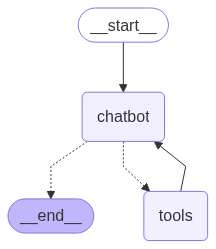

In [56]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable": {"thread_id": "1"}}

In [57]:
def stream_graph_updates(user_input: str) -> None:
    """Stream graph steps for a single input."""
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

In [60]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except Exception:
        user_input = "Hello. Please, initiate the conversation."
        stream_graph_updates(user_input)

================================ Human Message =================================


================================ Human Message =================================

Hello. Please, initiate the conversation.
================================== Ai Message ==================================

Hi there! I'm your friendly e-commerce assistant. I'm here to help you find products you might be interested in.

Is there something specific you're looking for today? Maybe you need:
- Electronics like smartphones or laptops
- Clothing items
- Home goods
- Beauty products
- Books or entertainment

Just let me know what you're searching for, and I can recommend some great options for you!
================================ Human Message =================================


================================ Human Message =================================

Hello. Please, initiate the conversation.
================================== Ai Message ==================================

Hi there! I'm your friendly e-

In [41]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='66e18839-dddc-4f6a-831b-381bc0d6679d'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='00d0b37b-0599-40af-814e-0489ae8c3e7e'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='9a836144-aa25-4f93-a851-f716941fe0e1'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='a1bd881f-76de-4eeb-a9d7-d987c5c0c47d'), AIMessage(content="Hello! I'm here to help you find products. Is there something specific you're looking for today? I can recommend products based on your interests or needs. Just let me know what you're interested in, and I'll help you find relevant options.", additional_kwargs={}, response_metadata={'id': 'msg_01HhSc9srzVcPSTsWPkD3McN', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_t